# Load modules

In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt

# Load file with resolved tidal data

In [2]:
NC = netCDF4.Dataset('/home/henell/WORK/tools/GETM/setups/warner/warner.3d.nc')
time = NC.variables['time'][1:] # exclude initial tidal snapshot (avoid double-couting during tidal averaging)
dx = NC.variables['dx'][:]
dy = NC.variables['dy'][:]

## Location of cross-section

In [3]:
i = 45 ; j = 0

In [4]:
xcl = NC.variables['xc'][i]
xcr = NC.variables['xc'][i+1]
xi = 0.5 * ( xcl + xcr ) # average to U-point interface between center cells
print( 'Analyze cross-section ', xi/1000, ' km upstream of open boundary.' )

Analyze cross-section  22.5  km upstream of open boundary.


## Analyze water depth

Read bathymetry (water depth below z=0):

In [5]:
bathyl = NC.variables['bathymetry'][j,i]
bathyr = NC.variables['bathymetry'][j,i+1]
bathyi = 0.5 * ( bathyl + bathyr ) # average to U-point interface between center cells

Read time-varying sea surface elevation (water height above z=0):

In [6]:
elevl = NC.variables['elev'][:,j,i]
elevr = NC.variables['elev'][:,j,i+1]
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] ) # average in space and time

Calculate time-varying water depth:

In [7]:
Di = bathyi + elevi

Calculate mean water depth:

In [8]:
Di_mean = Di.mean()

Show in a plot:

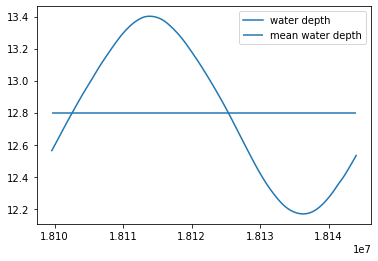

In [9]:
plt.plot( time , Di , label = 'water depth' )
plt.hlines( Di_mean , xmin = time[0] , xmax = time[-1] , label = 'mean water depth' )
plt.legend()
plt.show()

## Analyze depth-averaged velocity

time-varying depth-averaged velocity:

In [10]:
u2d = NC.variables['u'][1:,j,i]

In [11]:
u2d_mean = u2d.mean()
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-averaged velocity is <u2d> = -0.01744917


## Analyze depth-integrated transport

In [12]:
Di_mean_u2d_mean = Di_mean * u2d_mean
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = ', dy*Di_mean_u2d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u2d> =  -111.63073033094406


Q: Why does this value not reproduce the river input Qr=50 ???  
A: Because we have to calculate `dy*<D*u2d>` !!!

Calculate time-varying depth-integrated transport:

In [13]:
Du2d = Di * u2d

In [14]:
Du2d_mean = Du2d.mean()
print( 'Mean depth-integrated transport is dy*<D*u2d> =', dy*Du2d_mean )

Mean depth-integrated transport is dy*<D*u2d> = -51.95033550262451


Q: Why is there still a deviation between `dy*<D*u2d>` and Qr ???  
A: Slightly non-periodic model state

## Define mean transport velocity

In [15]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> =', u2d_twa )
print( 'Mean depth-averaged velocity was <u2d> =', u2d_mean )

Mean depth-integrated transport velocity is <D*u2d>/<D> = -0.008120437
Mean depth-averaged velocity was <u2d> = -0.01744917


`u2d_twa = <D*u2d>/<D>` is the mean velocity consistent with the volume transport !!!

## 2D guess for Qin and Qout

In [16]:
Du2d_in  =  np.fmax( 0 , Du2d ) # only consider positive transports
Du2d_out = -np.fmin( Du2d , 0 ) # only consider negative transports
Qin_2d  = Du2d_in.mean() * dy
Qout_2d = Du2d_out.mean() * dy
print( '2D guess for Qin is dy*<(D*u2d)^+> =', Qin_2d )
print( '2D guess for Qout is -dy*<(D*u2d)^-> =', Qout_2d )

2D guess for Qin is dy*<(D*u2d)^+> = 1272.9873657226562
2D guess for Qout is -dy*<(D*u2d)^-> = 1324.9376841953822


## Check volume balance

In [17]:
t0 = NC.variables['time'][ 0]
t1 = NC.variables['time'][-1]
bathy = NC.variables['bathymetry'][j,i+1:]
elev0 = NC.variables['elev'][ 0,j,i+1:]
elev1 = NC.variables['elev'][-1,j,i+1:]
D0 = bathy + elev0
D1 = bathy + elev1
V0 = D0.sum() * dx * dy
V1 = D1.sum() * dx * dy
print(' dV/dt =', ( V1 - V0 ) / ( t1 - t0 ) )
print(' Qin - Qout + Qr =', Qin_2d - Qout_2d + 50 )

 dV/dt = 0.039201612318200726
 Qin - Qout + Qr = -1.9503184727259395


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance is ok (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!

# Analyze depth-resolved data

## Calculate layer heights and vertical positions

In [18]:
if 'h' in NC.variables.keys():
    hl = NC.variables['h'][:,1:,j,i]
    hr = NC.variables['h'][:,1:,j,i+1]
    hi = 0.25 * ( hl[:-1,:] + hl[1:,:] + hr[:-1,:] + hr[1:,:] ) # average in space and time
elif 'sigma' in NC.variables.keys():
    sigma = NC.variables['sigma'][:]
    hi = np.outer( Di , np.diff(sigma) )
else:
    # assume equidistant sigma coordinates
    kmax = u3d.shape[1]
    hi = np.outer( Di , np.ones(kmax) / kmax )

In [19]:
zwi = np.insert( hi, 0, -bathyi, axis=1 ).cumsum(axis=1) # interface position
zci = 0.5 * ( zwi[:,:-1] + zwi[:,1:] ) # center position

## Analyze depth-resolved velocity

In [20]:
u3d = NC.variables['uu'][1:,1:,j,i]

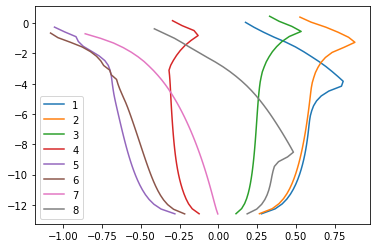

In [21]:
nmax = u3d.shape[0]
nprofs = 8 # should be multiple of 4
for n in range(nmax):
    if not (n+1)%(nmax//nprofs): plt.plot(u3d[n,:],zci[n,:], label=str((n+1)//(nmax//nprofs)))
plt.legend()    
plt.show()

### Mean depth-resolved velocity

In [22]:
u3d_mean = u3d.mean(axis=0)

### Mean depth-resolved transport velocity

In [23]:
hu3d = hi * u3d
hu3d_mean = hu3d.mean(axis=0)
hi_mean = hi.mean(axis=0)
u3d_twa = hu3d_mean / hi_mean

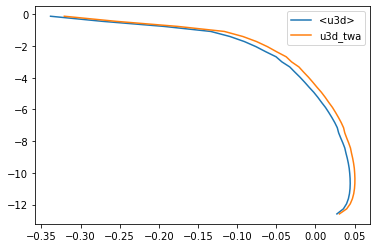

dy*sum(<h>*<u3d>) = -111.62184168130001
dy*sum(<h>*<u3d_twa>) = -50.102346322944186
Mean depth-integrated transport was dy*<D*u2d> = -51.95033550262451


In [24]:
zci_mean = zci.mean(axis=0)
plt.plot(u3d_mean, zci_mean, label='<u3d>')
plt.plot(u3d_twa, zci_mean, label='u3d_twa')
plt.legend()
plt.show()
print( 'dy*sum(<h>*<u3d>) =', dy * np.sum( hi_mean * u3d_mean ) )
print( 'dy*sum(<h>*<u3d_twa>) =', dy * np.sum( hi_mean * u3d_twa ) )
print( 'Mean depth-integrated transport was dy*<D*u2d> =', dy*Du2d_mean )

==> `u3d_twa = <h*u3d>/<h>` is the mean depth-resolved velocity consistent with the volume transport !!!

### 3D guess for Qin and Qout

In [25]:
hu3d_in  =  np.fmax( 0 , hu3d ) # only consider positive transports
hu3d_out = -np.fmin( hu3d , 0 ) # only consider negative transports
Qin_3d  = hu3d_in.sum(axis=1).mean() * dy
Qout_3d = hu3d_out.sum(axis=1).mean() * dy
print( '3D guess for Qin is dy*<sum( (h*u3d)^+ )> =', Qin_3d )
print( '3D guess for Qout is -dy*<sum( (h*u3d)^- )> =', Qout_3d )
print( 'Qin - Qout =', Qin_3d - Qout_3d)
print( '2D guess for Qin was dy*<(D*u2d)^+> =', Qin_2d )
print( '2D guess for Qout was -dy*<(D*u2d)^-> =', Qout_2d )

3D guess for Qin is dy*<sum( (h*u3d)^+ )> = 1324.049695037166
3D guess for Qout is -dy*<sum( (h*u3d)^- )> = 1374.1520413601102
Qin - Qout = -50.102346322944186
2D guess for Qin was dy*<(D*u2d)^+> = 1272.9873657226562
2D guess for Qout was -dy*<(D*u2d)^-> = 1324.9376841953822


# Binning into salinity classes

In [ ]:
salt = id_file.variables['salt'][:-1,1:,j,i] #include initial, but exclude final state

In [ ]:
nbins = 10
Smin = salt.min()-1e-10
Smax = salt.max()
Si = np.linspace( Smin , Smax , nbins+1 )
S_s = 0.5 * ( Si[:-1] + Si[1:] )

In [ ]:
h_s   = np.zeros((nmax,nbins+1))
hu_s  = np.zeros((nmax,nbins+1))
hus_s = np.zeros((nmax,nbins+1))
for n in range(nmax):
    for k in range(kmax):
        bin = max( 0 , int( np.ceil( (salt[n,k]-Si[0])/(Si[nbins]-Si[0])*nbins ) ) )
        if bin > nbins: continue
        h_s  [n,bin] = h_s  [n,bin] + hi[n,k]
        hu_s [n,bin] = hu_s [n,bin] + hi[n,k]*u3d[n,k]
        hus_s[n,bin] = hus_s[n,bin] + hi[n,k]*u3d[n,k]*salt[n,k]

In [ ]:
h_s_mean   = h_s.mean(axis=0)
hu_s_mean  = hu_s.mean(axis=0)
hus_s_mean = hus_s.mean(axis=0)
u_s_twa = np.zeros_like(h_s_mean)
np.divide( hu_s_mean , h_s_mean , out = u_s_twa , where = (h_s_mean > 0) ) ;

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(u_s_twa[1:], S_s)
ax.invert_yaxis()
ax.set(xlabel='velocity [ms$^{-1}$]',ylabel='salinity [gkg$^{-1}$]')
print( 'dy*sum(hu_s_mean) =' , dy*hu_s_mean.sum() )